This notebook only makes a figure out of pre-computed behavior predictions.
It relies on finding a summary file in the `results` folder.

To recompute ad reproduce these results from scratch, one would need to run the following scripts:
1. `./scripts/chewie/extract_data.py` to save the ground truth data
2. `./scripts/chewie/run_biRNN_decoder.py` to save the results of the biRNN decoder 
3. `./scripts/chewie/run_avg_per_epoch.py` to save the trial-average per-condition predictions
4. LFADS / BAND
5. PSID
6. CEBRA

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from plot_helpers import get_trials2plot

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [11]:
path = '../../results/Chewie_CO_FF_2016-10-05.h5'
data = {}
with h5py.File(path, 'r') as f:
   for key in f.keys():
      data[key] = f[key][()]
data.keys()

dict_keys(['test_M1_birnn_pred', 'test_M1_cebra_pred', 'test_PMd_birnn_pred', 'test_PMd_cebra_pred', 'test_all_avg_per_epoch_pred', 'test_all_birnn_pred', 'test_all_cebra_pred', 'train_M1_birnn_pred', 'train_M1_cebra_pred', 'train_PMd_birnn_pred', 'train_PMd_cebra_pred', 'train_all_avg_per_epoch_pred', 'train_all_birnn_pred', 'train_all_cebra_pred', 'train_behavior', 'train_epoch', 'train_inds', 'train_target_direction', 'valid_behavior', 'valid_epoch', 'valid_inds', 'valid_target_direction'])

<IPython.core.display.Javascript object>

In [12]:
dset='valid'
vel = data[f'{dset}_behavior'][:]
target_direction = data[f'{dset}_target_direction'][:]
epoch = data[f'{dset}_epoch'][:]
pos = np.cumsum(vel, axis=1)

<IPython.core.display.Javascript object>

In [13]:
dir_index = np.array([
        sorted(set(target_direction)).index(i) for i in target_direction
    ])

avg_vel_per_epoch = data['test_all_avg_per_epoch_pred']


<IPython.core.display.Javascript object>

In [14]:
trials2plot = np.array([get_trials2plot(vel, avg_vel_per_epoch, dir_index, epoch, i) for i in range(3)]).sum(0)
trials2plot.sum()

24

<IPython.core.display.Javascript object>

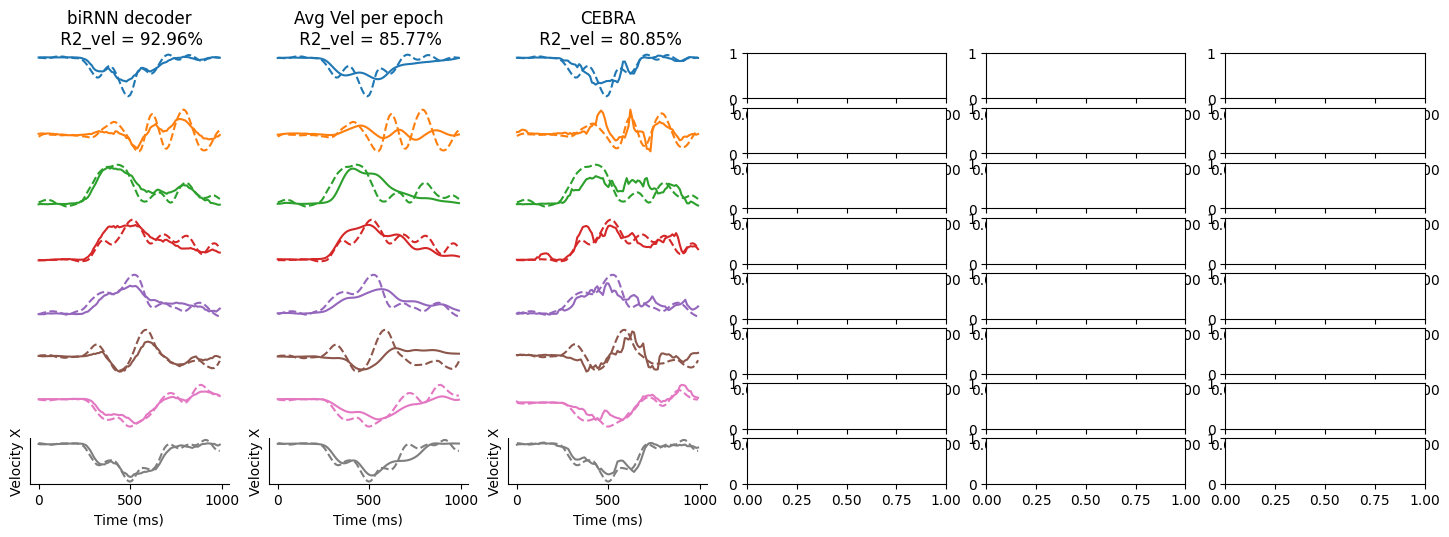

<IPython.core.display.Javascript object>

In [19]:
def plot_beh_pred(vel, pred_vel, dir_index, trials2plot, axes, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if trials2plot[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X")

    R2_iso_vel = 1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)
    axes[0].set_title(f'{title}\n R2_vel = {R2_iso_vel*100:.2f}%')
    

fig, axes = plt.subplots(8,6,figsize=(6*3, 8*.7))

epoch_mask = epoch==1
component = 0

area = 'all'
for i, (key, title) in enumerate(zip([f'test_{area}_birnn_pred','test_all_avg_per_epoch_pred',f'test_{area}_cebra_pred'],
                                  ['biRNN decoder', 'Avg Vel per epoch','CEBRA'])):

    plot_beh_pred(vel[epoch_mask], 
                data[key][epoch_mask], 
                dir_index[epoch_mask], 
                trials2plot[epoch_mask], 
                axes[:,i], 
                component=0, 
                title=title)

fig.savefig("figs/Figure4")

In [37]:
# loop through epochs (x3)
# loop through areas (keeping all for Avg) (x3)
# loop through components (x2)

# 18 figures in total. Paper: AD and all 3 areas, X coordinate

<IPython.core.display.Javascript object>